In [112]:
import geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import pyrosm
import osmnx as ox
import momepy
import pygeos
import libpysal
import scipy
import glob
import networkx as nx
from tqdm import tqdm
import rioxarray
import xarray
import rasterstats
from download import download
import cenpy
import contextily
import pandana
import utils.momepy
from dask.distributed import Client, LocalCluster
import fiona
import utils
from shapely.geometry import box, mapping
from numpy import percentile
import os
import subprocess

from utils.momepy_utils import (
    _circle_radius,
    centroid_corner,
    elongation,
    get_corners,
    get_edge_ratios,
    get_nodes,
    solar_orientation_poly,
    squareness,
)

import utils.consolidate
from time import time

In [4]:
import warnings

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [4]:
folder = "../../urbangrammar_samba/sp_sig_concept/singapore/"

### Street network

In [5]:
%%time
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_place("Singapore", network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = folder + 'roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

CPU times: user 1min 50s, sys: 912 ms, total: 1min 51s
Wall time: 3min 39s


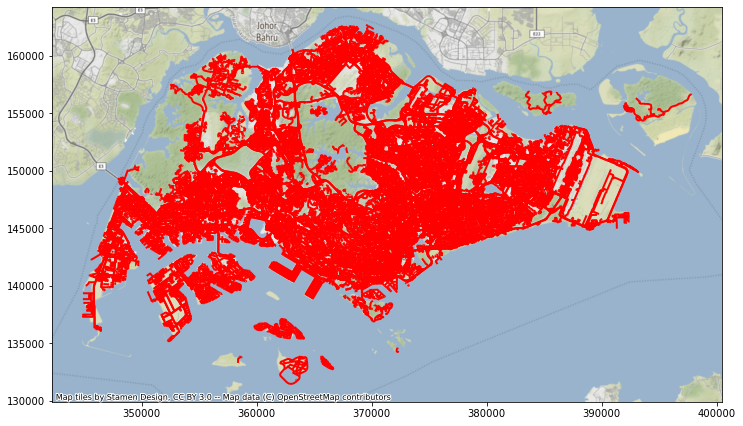

In [6]:
ax = gdf.plot(figsize=(12, 12), color='red', linewidth=2)
contextily.add_basemap(ax=ax, crs=gdf.crs)

### Buildings

In [7]:
%%time
footprints = ox.geometries_from_place("Singapore", tags={'building':True})
footprints_proj = ox.projection.project_gdf(footprints)
path = folder + 'footprints_osm.pq'
footprints_proj[['building', 'building:levels', 'geometry']].to_parquet(path)

<timed exec>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


CPU times: user 2min 42s, sys: 1.52 s, total: 2min 44s
Wall time: 7min 27s


### Barriers

In [57]:
%%time
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_place("Singapore", tags)
path = folder + 'water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

CPU times: user 995 ms, sys: 28.2 ms, total: 1.02 s
Wall time: 3min 21s


<timed exec>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


<AxesSubplot:>

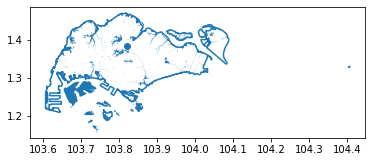

In [58]:
gdf.plot()

In [9]:
tags = {'railway': True}
gdf = ox.geometries_from_place("Singapore", tags)
gdf = gdf[gdf.geom_type == 'LineString']
gdf = gdf[gdf.tunnel != 'yes']
path = folder + 'railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-0665a01ef50c>:6: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf[['railway', 'geometry']].to_parquet(path)


## Data preprocessing

In [13]:
buildings = gpd.read_parquet(folder + 'footprints_osm.pq')

In [14]:
buildings.geom_type.value_counts()

Polygon         108661
Point               94
MultiPolygon        39
LineString           2
dtype: int64

In [15]:
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)
buildings = buildings[buildings.geom_type == 'Polygon']

In [16]:
%time check = momepy.CheckTessellationInput(buildings)

/opt/conda/lib/python3.8/site-packages/momepy/utils.py:1003: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  shrink = shrink[~(shrink.is_empty | shrink.geometry.isna())]


Collapsed features  : 5
Split features      : 34
Overlapping features: 779
CPU times: user 10.5 s, sys: 229 ms, total: 10.7 s
Wall time: 10.4 s


In [17]:
buildings = buildings.drop(check.collapse.index.union(check.overlap.index))

In [18]:
buildings.shape

(108019, 3)

In [19]:
buildings.is_valid.all()

True

In [20]:
buildings["uID"] = range(len(buildings))
%time buildings.to_parquet(folder + "buildings.pq")

<timed eval>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


CPU times: user 279 ms, sys: 20.3 ms, total: 299 ms
Wall time: 484 ms


In [6]:
roads = gpd.read_parquet(folder + "roads_osm.pq").to_crs(buildings.crs)

In [7]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [8]:
railway = gpd.read_parquet(folder + "railway_osm.pq").to_crs(buildings.crs)

In [9]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

In [10]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [11]:
water = gpd.read_parquet(folder + "water_osm.pq").to_crs(buildings.crs)

In [12]:
water.geom_type.value_counts()

Polygon         1066
LineString       189
MultiPolygon       2
Point              1
dtype: int64

In [13]:
mask = water.geom_type.isin(["MultiPolygon", "Polygon"])

In [14]:
water.loc[mask, "geometry"] = water[mask].boundary

In [15]:
from shapely.ops import polygonize

In [16]:
limit = gpd.GeoSeries(polygonize(water.geometry.unary_union)).unary_union

In [17]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=gpd.GeoSeries([limit]), additional_barriers=[extended_railway, water])

CPU times: user 11.8 s, sys: 31.5 ms, total: 11.8 s
Wall time: 11.8 s


<AxesSubplot:>

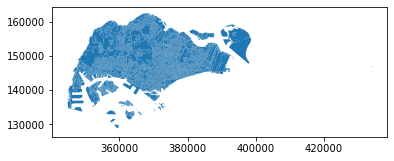

In [18]:
enclosures.plot()

In [19]:
enclosures.is_valid.all()

True

In [20]:
enclosures.to_parquet(folder + "enclosures.pq")

In [84]:
client = Client(LocalCluster(n_workers=16))
client

<Client: 'tcp://127.0.0.1:36241' processes=16 threads=16, memory=134.91 GB>

In [85]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

/opt/conda/lib/python3.8/site-packages/distributed/worker.py:3373: UserWarning: Large object of size 36.81 MB detected in task graph: 
  ([         eID                                     ...  0.05, 'uID'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 1min 6s, sys: 12.1 s, total: 1min 18s
Wall time: 9min 31s


In [88]:
tessellation = tess.tessellation
tessellation['tID'] = range(len(tessellation))
tessellation.to_parquet(folder + "tessellation.pq")

<ipython-input-88-1bd0dacfcfba>:3: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tessellation.to_parquet(folder + "tessellation.pq")


## Primary morphometric characters

In [21]:
tess = gpd.read_parquet(folder + "tessellation.pq")
blg = gpd.read_parquet(folder + "buildings.pq")
streets = gpd.read_parquet(folder + 'roads_osm.pq')
enclosures = gpd.read_parquet(folder + "enclosures.pq")

In [23]:
tess.crs == blg.crs == streets.crs == enclosures.crs

True

In [24]:
tess = tess.rename_geometry("tessellation").merge(blg[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [25]:
tess

uID                                       tessellation    eID  \
0       15894.0  POLYGON ((375169.266 143445.969, 375215.555 14...     45   
1       15895.0  POLYGON ((375570.371 143269.939, 375570.488 14...     45   
2       16484.0  POLYGON ((375768.304 143392.659, 375757.980 14...     45   
3       26213.0  POLYGON ((375754.329 143271.830, 375752.662 14...     45   
4       26214.0  POLYGON ((375747.372 143332.482, 375749.257 14...     45   
...         ...                                                ...    ...   
134917      NaN  POLYGON ((383523.192 154933.560, 383510.203 15...  33861   
134918      NaN  POLYGON ((380708.975 157411.368, 380707.697 15...  33862   
134919      NaN  POLYGON ((353645.118 158537.917, 353608.695 15...  33863   
134920      NaN  POLYGON ((394664.531 158413.756, 394665.472 15...  33864   
134921      NaN  POLYGON ((372888.167 160290.008, 372908.495 16...  33865   

           tID                                          buildings  
0            0  POLYGON ((375488.721 143388.836, 375488.947 14...  
1            1  POLYGON ((375601.423 143437.208, 375625.880 14...  
2            2  POLYGON ((375756.182 143428.539, 375753.645 14...  
3            3  POLYGON ((375780.585 143356.902, 375787.024 14...  
4            4  POLYGON ((375697.450 143341.561, 375690.673 14...  
...        ...                                                ...  
134917  134917                                               None  
134918  134918                                               None  
134919  134919                                               None  
134920  134920                                               None  
134921  134921                                               None  

[134922 rows x 5 columns]

In [26]:
blg = tess.set_geometry('buildings').dropna()

In [27]:
%time blg['sdbAre'] = momepy.Area(blg).series
%time blg['sdbPer'] = momepy.Perimeter(blg).series
%time blg['sdbCoA'] = momepy.CourtyardArea(blg, 'sdbAre').series

%time blg['ssbCCo'] = momepy.CircularCompactness(blg, 'sdbAre').series
%time blg['ssbCor'] = momepy.Corners(blg).series
%time blg['ssbSqu'] = momepy.Squareness(blg).series
%time blg['ssbERI'] = momepy.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
%time blg['ssbElo'] = momepy.Elongation(blg).series
%time cencon = momepy.CentroidCorners(blg)
blg['ssbCCM'] = cencon.mean
blg['ssbCCD'] = cencon.std

%time blg['stbOri'] = momepy.Orientation(blg).series
 
%time tess['stcOri'] = momepy.Orientation(tess).series

tess = tess.merge(blg[['tID', 'stbOri']], on='tID', how='left')

%time tess['stbCeA'] = (tess['stbOri'] - tess['stcOri']).abs()

%time tess['sdcLAL'] = momepy.LongestAxisLength(tess).series
%time tess['sdcAre'] = momepy.Area(tess).series
%time tess['sscCCo'] = momepy.CircularCompactness(tess, 'sdcAre').series
%time tess['sscERI'] = momepy.EquivalentRectangularIndex(tess, 'sdcAre').series

%time tess['sicCAR'] = tess.buildings.area / tess['sdcAre']
%time blg["mtbSWR"] = momepy.SharedWallsRatio(blg).series

CPU times: user 27.3 ms, sys: 300 µs, total: 27.6 ms
Wall time: 26.2 ms
CPU times: user 24.2 ms, sys: 0 ns, total: 24.2 ms
Wall time: 23.7 ms
CPU times: user 1.95 s, sys: 10.7 ms, total: 1.96 s
Wall time: 1.96 s


  1%|          | 736/109715 [00:00<00:14, 7357.17it/s]

CPU times: user 6.52 s, sys: 3.47 ms, total: 6.52 s
Wall time: 6.52 s


  7%|▋         | 7843/109715 [00:01<00:18, 5652.07it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:765: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
 19%|█▉        | 20782/109715 [00:03<00:13, 6654.19it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:766: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 452/109715 [00:00<00:24, 4515.63it/s]

CPU times: user 20.2 s, sys: 114 ms, total: 20.3 s
Wall time: 20.2 s


  7%|▋         | 7968/109715 [00:02<00:33, 3013.83it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:853: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
 19%|█▉        | 20968/109715 [00:05<00:22, 4004.62it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:854: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
 83%|████████▎ | 90977/109715 [00:25<00:05, 3155.58it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 109715/109715 [00:32<00:00, 3351.97it/s]


CPU times: user 32.7 s, sys: 288 ms, total: 33 s
Wall time: 32.7 s
CPU times: user 31.6 s, sys: 17.5 ms, total: 31.6 s
Wall time: 31.6 s


  0%|          | 339/109715 [00:00<00:32, 3387.70it/s]

CPU times: user 31.5 s, sys: 19.4 ms, total: 31.5 s
Wall time: 31.5 s


  7%|▋         | 7907/109715 [00:02<00:41, 2460.97it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1073: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
 19%|█▉        | 20892/109715 [00:06<00:27, 3206.67it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1074: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 342/109715 [00:00<00:31, 3418.96it/s]

CPU times: user 39.5 s, sys: 87.7 ms, total: 39.5 s
Wall time: 39.4 s


  0%|          | 83/134922 [00:00<02:42, 828.10it/s]

CPU times: user 35.4 s, sys: 99.8 ms, total: 35.5 s
Wall time: 35.5 s


100%|██████████| 134922/134922 [04:42<00:00, 477.24it/s] 


CPU times: user 4min 42s, sys: 534 ms, total: 4min 43s
Wall time: 4min 42s
CPU times: user 1.69 ms, sys: 16 µs, total: 1.7 ms
Wall time: 1.1 ms
CPU times: user 32.7 s, sys: 7.68 ms, total: 32.7 s
Wall time: 32.7 s
CPU times: user 139 ms, sys: 38 µs, total: 139 ms
Wall time: 139 ms
CPU times: user 34.5 s, sys: 19.8 ms, total: 34.5 s
Wall time: 34.5 s
CPU times: user 4min 33s, sys: 163 ms, total: 4min 33s
Wall time: 4min 33s
CPU times: user 23 ms, sys: 24 µs, total: 23 ms
Wall time: 21.6 ms
CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


In [28]:
%time queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="tID", geom_col='tessellation')
%time tess["mtbAli"] = momepy.Alignment(tess.set_geometry("buildings"), queen_1, "tID", "stbOri").series
%time tess["mtbNDi"] = utils.momepy.NeighborDistance(tess.set_geometry("buildings"), queen_1, "tID").series
%time tess["mtcWNe"] = momepy.Neighbors(tess, queen_1, "tID", weighted=True).series
%time tess["mdcAre"] = momepy.CoveredArea(tess, queen_1, "tID").series
%time blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blg, geom_col='buildings', silence_warnings=True)
 
%time blg["ldbPWL"] = momepy.PerimeterWall(blg, blg_q1).series
%time blg["libNCo"] = utils.momepy.Courtyards(blg, spatial_weights=blg_q1).series
%time queen_3 = momepy.sw_high(k=3, weights=queen_1)
%time tess['ltbIBD'] = utils.momepy.MeanInterbuildingDistance(tess.set_geometry('buildings'), queen_1, 'tID', queen_3).series

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 42 islands with ids: 122813, 122879, 125563, 134751, 134752, 134753, 134754, 134755, 134756, 134757, 134758, 134759, 134760, 134761, 134762, 134763, 134764, 134766, 134767, 134768, 134770, 134771, 134772, 134773, 134774, 134775, 134776, 134777, 134778, 134779, 134780, 134781, 134782, 134784, 134786, 134800, 134801, 134802, 134918, 134919, 134920, 134921.
  warnings.warn(message)
  0%|          | 243/134922 [00:00<00:55, 2421.76it/s]

CPU times: user 1min 59s, sys: 2.46 s, total: 2min 2s
Wall time: 2min 2s


  0%|          | 232/134922 [00:00<00:58, 2317.06it/s]

CPU times: user 56.8 s, sys: 2.42 s, total: 59.2 s
Wall time: 56.6 s


  7%|▋         | 9482/134922 [00:00<00:01, 94819.19it/s]

CPU times: user 49.1 s, sys: 120 ms, total: 49.2 s
Wall time: 49 s


  0%|          | 0/134922 [00:00<?, ?it/s]

CPU times: user 1.47 s, sys: 37 µs, total: 1.47 s
Wall time: 1.47 s


100%|██████████| 134922/134922 [00:22<00:00, 5976.90it/s]


CPU times: user 23.1 s, sys: 2.26 s, total: 25.3 s
Wall time: 22.8 s
CPU times: user 7.95 s, sys: 116 ms, total: 8.07 s
Wall time: 8.06 s


  0%|          | 161/109715 [00:00<01:08, 1608.21it/s]

CPU times: user 1min 28s, sys: 22.1 s, total: 1min 50s
Wall time: 1min 11s


100%|██████████| 109715/109715 [01:31<00:00, 1200.80it/s]


CPU times: user 1min 50s, sys: 20.9 s, total: 2min 11s
Wall time: 1min 31s
CPU times: user 13.1 s, sys: 431 ms, total: 13.6 s
Wall time: 13.6 s


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:308: UserWarning: {} islands in this weights matrix. Conversion to an adjacency list will drop these observations!
  warnings.warn(
  0%|          | 200/134922 [00:00<02:09, 1036.75it/s]

Computing mean interbuilding distances...


 76%|███████▌  | 102173/134922 [01:35<00:38, 842.07it/s] /home/jovyan/work/spatial_signatures_concept/code/utils/momepy.py:1099: RuntimeWarning: Mean of empty slice
  np.nanmean([x[-1] for x in list(sub.edges.data("weight"))])
100%|██████████| 134922/134922 [02:21<00:00, 951.76it/s] 


CPU times: user 2min 31s, sys: 1.19 s, total: 2min 32s
Wall time: 2min 30s


In [29]:
# get nid and primary nid here
%time links = utils.momepy.get_network_ratio(tess, streets)
tess[['edgeID_keys', 'edgeID_values']] = links
keys = tess.edgeID_values.apply(lambda a: np.argmax(a))
tess['edgeID_primary'] = [inds[i] for inds, i in zip(tess.edgeID_keys, keys)]
blg = blg.merge(tess[['tID', 'edgeID_primary']], on='tID', how='left')
streets['edgeID_primary'] = range(len(streets))

/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


CPU times: user 4min 49s, sys: 16.9 ms, total: 4min 49s
Wall time: 4min 49s


In [30]:
%time streets["sdsLen"] = momepy.Perimeter(streets).series
%time tess["stcSAl"] = momepy.StreetAlignment(tess, streets, "stcOri", "edgeID_primary").series
%time blg["stbSAl"] = momepy.StreetAlignment(blg, streets, "stbOri", "edgeID_primary").series

CPU times: user 6.43 ms, sys: 0 ns, total: 6.43 ms
Wall time: 5.38 ms
CPU times: user 2.99 s, sys: 0 ns, total: 2.99 s
Wall time: 2.99 s
CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 2.98 s


In [31]:
%time profile = momepy.StreetProfile(streets, blg, distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd

100%|██████████| 112298/112298 [44:39<00:00, 41.90it/s] 


CPU times: user 44min 41s, sys: 12.8 s, total: 44min 53s
Wall time: 44min 40s


In [32]:
%time streets["sssLin"] = momepy.Linearity(streets).series

CPU times: user 2.03 s, sys: 3.95 ms, total: 2.04 s
Wall time: 2.03 s


In [33]:
%%time 
# Area Covered by each edge
vals = {x:[] for x in range(len(streets))}
for i, keys in enumerate(tess.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(tess.sdcAre.iloc[inds].sum())
streets['sdsAre'] = area_sums

CPU times: user 10.1 s, sys: 3.36 ms, total: 10.1 s
Wall time: 10.1 s


In [34]:
%%time
# Buildings per meter
bpm = []
for inds, l in zip(vals.values(), streets.sdsLen):
    bpm.append(tess.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
streets['sisBpM'] = bpm

<timed exec>:4: RuntimeWarning: divide by zero encountered in true_divide


CPU times: user 32.5 s, sys: 66.7 ms, total: 32.6 s
Wall time: 32.5 s


In [35]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = momepy.Reached(
    streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1, mode="count"
).series
streets["mdsAre"] = momepy.Reached(streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1,
                               mode="sum").series

100%|██████████| 112298/112298 [04:26<00:00, 422.02it/s]


In [36]:
%time graph = momepy.gdf_to_nx(streets)
 
print("node degree")
graph = momepy.node_degree(graph)
 
print("subgraph")
graph = momepy.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = momepy.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = momepy.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = momepy.mean_node_dist(graph, name="mtdMDi")
 
%time nodes, edges, sw = momepy.nx_to_gdf(graph, spatial_weights=True)

CPU times: user 14.2 s, sys: 0 ns, total: 14.2 s
Wall time: 14.2 s
node degree
subgraph


100%|██████████| 85852/85852 [01:26<00:00, 987.31it/s] 


cds length


100%|██████████| 85852/85852 [00:32<00:00, 2647.43it/s]


clustering
mean_node_dist


100%|██████████| 85852/85852 [00:01<00:00, 75126.95it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1466 disconnected components.
  warnings.warn(message)


CPU times: user 4.41 s, sys: 3.81 ms, total: 4.41 s
Wall time: 4.41 s


In [37]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = momepy.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series

  1%|          | 1132/112298 [00:00<00:09, 11319.17it/s]

CPU times: user 9.74 s, sys: 196 ms, total: 9.93 s
Wall time: 9.93 s


100%|██████████| 112298/112298 [00:08<00:00, 13480.39it/s]


CPU times: user 8.63 s, sys: 807 ms, total: 9.44 s
Wall time: 8.37 s


  0%|          | 41/85852 [00:00<03:32, 402.95it/s]

CPU times: user 4.93 s, sys: 184 ms, total: 5.11 s
Wall time: 5.11 s


  0%|          | 33/85852 [00:00<04:27, 320.55it/s]

CPU times: user 3min 38s, sys: 308 ms, total: 3min 39s
Wall time: 3min 38s


100%|██████████| 85852/85852 [04:27<00:00, 321.07it/s]


In [38]:
enclosures["ldeAre"] = momepy.Area(enclosures).series
enclosures["ldePer"] = momepy.Perimeter(enclosures).series
enclosures["lseCCo"] = momepy.CircularCompactness(enclosures, "ldeAre").series
enclosures["lseERI"] = momepy.EquivalentRectangularIndex(enclosures, "ldeAre", "ldePer").series
enclosures["lseCWA"] = momepy.CompactnessWeightedAxis(enclosures, "ldeAre", "ldePer").series
enclosures["lteOri"] = momepy.Orientation(enclosures).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(enclosures, ids="eID")
 
inp, res = enclosures.sindex.query_bulk(enclosures.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
enclosures['neighbors'] = counts - 1
enclosures['lteWNB'] = enclosures['neighbors'] / enclosures['ldePer']

100%|██████████| 33866/33866 [00:16<00:00, 2005.34it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 47 islands with ids: 19982, 19983, 20067, 23041, 33683, 33684, 33685, 33686, 33687, 33689, 33691, 33692, 33693, 33694, 33695, 33696, 33697, 33698, 33699, 33700, 33703, 33704, 33705, 33708, 33709, 33710, 33711, 33712, 33713, 33714, 33715, 33716, 33717, 33718, 33719, 33720, 33721, 33724, 33727, 33728, 33743, 33744, 33745, 33862, 33863, 33864, 33865.
  warnings.warn(message)


In [39]:
# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = enclosures[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
enclosures['lieWCe'] = merged['tessellation'] / merged['ldeAre']

In [41]:
tess['ltcWRE'] = momepy.BlocksCount(tess, 'eID', queen_3, 'tID').series

100%|██████████| 134922/134922 [01:27<00:00, 1535.61it/s]


In [48]:
def get_node_id(
    objects,
    nodes,
    edges,
    node_id,
    edge_id=None,
    edge_keys=None,
    edge_values=None,
    verbose=True,
):
    nodes = nodes.set_index(node_id)

    if not isinstance(node_id, str):
        nodes["mm_noid"] = node_id
        node_id = "mm_noid"

    results_list = []
    if edge_id is not None:
        edges = edges.set_index(edge_id)
        centroids = objects.centroid
        for eid, centroid in tqdm(
            zip(objects[edge_id], centroids),
            total=objects.shape[0],
            disable=not verbose,
        ):
            if np.isnan(eid):
                results_list.append(np.nan)
            else:
                edge = edges.loc[eid]
                startID = edge.node_start
                start = nodes.loc[startID].geometry
                sd = centroid.distance(start)
                endID = edge.node_end
                end = nodes.loc[endID].geometry
                ed = centroid.distance(end)
                if sd > ed:
                    results_list.append(endID)
                else:
                    results_list.append(startID)

    elif edge_keys is not None and edge_values is not None:
        for edge_i, edge_r, geom in tqdm(
            zip(objects[edge_keys], objects[edge_values], objects.geometry),
            total=objects.shape[0],
            disable=not verbose,
        ):
            edge = edges.iloc[edge_i[edge_r.index(max(edge_r))]]
            startID = edge.node_start
            start = nodes.loc[startID].geometry
            sd = geom.distance(start)
            endID = edge.node_end
            end = nodes.loc[endID].geometry
            ed = geom.distance(end)
            if sd > ed:
                results_list.append(endID)
            else:
                results_list.append(startID)

    series = pd.Series(results_list, index=objects.index)
    return series


def get_network_ratio(df, edges, initial_buffer=500):
    # intersection-based join
    buff = edges.buffer(0.01)  # to avoid floating point error
    inp, res = buff.sindex.query_bulk(df.geometry, predicate="intersects")
    intersections = (
        df.iloc[inp]
        .reset_index(drop=True)
        .intersection(buff.iloc[res].reset_index(drop=True))
    )
    mask = intersections.area > 0.0001
    intersections = intersections[mask]
    inp = inp[mask]
    lengths = intersections.area
    grouped = lengths.groupby(inp)
    totals = grouped.sum()
    ints_vect = []
    for name, group in grouped:
        ratios = group / totals.loc[name]
        ints_vect.append({res[item[0]]: item[1] for item in ratios.iteritems()})

    edge_dicts = pd.Series(ints_vect, index=totals.index)

    # nearest neighbor join
    nans = df.index.difference(edge_dicts.index)
    buffered = df.iloc[nans].buffer(initial_buffer)
    additional = []
    for orig, geom in zip(df.iloc[nans].geometry, buffered.geometry):
        query = edges.sindex.query(geom, predicate="intersects")
        b = initial_buffer
        while query.size == 0:
            query = edges.sindex.query(geom.buffer(b), predicate="intersects")
            b += initial_buffer
        additional.append({edges.iloc[query].distance(orig).idxmin(): 1})

    additional = pd.Series(additional, index=nans)
    ratios = pd.concat([edge_dicts, additional]).sort_index()
    result = pd.DataFrame()
    result["edgeID_keys"] = ratios.apply(lambda d: list(d.keys()))
    result["edgeID_values"] = ratios.apply(lambda d: list(d.values()))
    result.index = df.index
    return result

In [49]:
# get node id
%time links = get_network_ratio(tess, edges)
tess[['edgeID_keys2', 'edgeID_values2']] = links
%time tess['nodeID'] = get_node_id(tess, nodes, edges, node_id='nodeID', edge_keys='edgeID_keys2', edge_values='edgeID_values2')

/opt/conda/lib/python3.8/site-packages/pygeos/measurement.py:55: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
  0%|          | 292/134922 [00:00<00:46, 2919.56it/s]

CPU times: user 4min 47s, sys: 121 ms, total: 4min 47s
Wall time: 4min 47s


100%|██████████| 134922/134922 [00:46<00:00, 2886.11it/s]

CPU times: user 46.8 s, sys: 139 ms, total: 46.9 s
Wall time: 46.8 s


In [50]:
%%time
nodes["sddAre"] = momepy.Reached(
    nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series

100%|██████████| 85852/85852 [01:39<00:00, 864.99it/s]


CPU times: user 1min 39s, sys: 174 ms, total: 1min 39s
Wall time: 1min 39s


In [51]:
tess.to_parquet(folder + "tess.pq")
blg.to_parquet(folder + "blg.pq")
nodes.to_parquet(folder + "nodes.pq")
edges.to_parquet(folder + "edges.pq")
enclosures.to_parquet(folder + "enclosures.pq")

In [52]:
data = tess.merge(
    blg[['tID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl', 'libNCo']],
    on='tID',
    how='left'
)
data = data.merge(
    edges[["sdsLen", 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'edgeID_primary']],
    on='edgeID_primary',
    how='left'
)
data = data.merge(
    nodes[['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'lddNDe', 'linWID', 'sddAre']],
    on='nodeID',
    how='left'
)
data = data.merge(
    enclosures[['eID', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']],
    on='eID',
    how='left'
)

In [53]:
data.columns

Index(['uID', 'tessellation', 'eID', 'tID', 'buildings', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [54]:
characters = ['stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD',
       'stcSAl', 'ltcWRE',
       'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']

In [55]:
data[characters + ['tID', 'uID', 'tessellation', 'buildings']].to_parquet(folder + "data.pq")

### Convolutions

In [56]:
data = gpd.read_parquet(folder + "data.pq")

gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
%time W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(data, geom_col='tessellation'))

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 42 islands with ids: 122813, 122879, 125563, 134751, 134752, 134753, 134754, 134755, 134756, 134757, 134758, 134759, 134760, 134761, 134762, 134763, 134764, 134766, 134767, 134768, 134770, 134771, 134772, 134773, 134774, 134775, 134776, 134777, 134778, 134779, 134780, 134781, 134782, 134784, 134786, 134800, 134801, 134802, 134918, 134919, 134920, 134921.
  warnings.warn(message)


CPU times: user 9min 21s, sys: 18.6 s, total: 9min 39s
Wall time: 9min 38s


In [57]:
convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i, geom in tqdm(gdf.geometry.iteritems(), total=data.shape[0]):
    neighbours = W.neighbors[i]
    vicinity = gdf.iloc[neighbours]
    distance = vicinity.distance(geom)
    distance_decay = (1 / distance).replace(np.inf, 0)  # to filter out duplications
    
    for c in characters:
        values = vicinity[c].values
        sorter = np.argsort(values)
        values = values[sorter]
        nan_mask = np.isnan(values)
        if nan_mask.all():
            convolutions[c].append(np.array([np.nan] * 3))
        else:
            sample_weight = distance_decay.values[sorter][~nan_mask]
            weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
            weighted_quantiles /= np.sum(sample_weight)
            interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
            convolutions[c].append(interpolate)

100%|██████████| 134922/134922 [18:11<00:00, 123.62it/s]


In [58]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 1.68 s, sys: 28 ms, total: 1.71 s
Wall time: 1.71 s
CPU times: user 11 s, sys: 87.8 ms, total: 11.1 s
Wall time: 11.1 s


In [59]:
exploded.index = data.tID
exploded

stcOri_q1  stcOri_q2  stcOri_q3  stbOri_q1  stbOri_q2  stbOri_q3  \
tID                                                                        
0        4.918459  13.993348  24.716206   2.457620  10.048209  20.377200   
1        4.046792  11.493947  24.015725   1.735927   6.556407  17.533124   
2        3.908333  10.928475  23.312707   1.634927   7.308449  17.912730   
3        4.257322  12.295326  24.087086   1.910446   9.230551  18.652053   
4        4.136550  11.906694  24.085175   1.912812   8.889390  18.603212   
...           ...        ...        ...        ...        ...        ...   
134917  12.812096  13.290695  34.451149        NaN        NaN        NaN   
134918        NaN        NaN        NaN        NaN        NaN        NaN   
134919        NaN        NaN        NaN        NaN        NaN        NaN   
134920        NaN        NaN        NaN        NaN        NaN        NaN   
134921        NaN        NaN        NaN        NaN        NaN        NaN   

        stbCeA_q1  stbCeA_q2  stbCeA_q3  sdcLAL_q1  ...   lseCWA_q3  \
tID                                                 ...               
0        0.512334   2.116416   6.589920  41.469409  ...  434.226926   
1        0.571959   2.257862   7.117899  42.256321  ...  677.484180   
2        0.535426   2.228739   6.452241  42.024054  ...  498.196752   
3        0.502753   2.032704   5.919926  41.216075  ...  434.226926   
4        0.568613   2.303353   7.105044  42.143070  ...  677.484180   
...           ...        ...        ...        ...  ...         ...   
134917        NaN        NaN        NaN  87.577522  ...  517.751521   
134918        NaN        NaN        NaN        NaN  ...         NaN   
134919        NaN        NaN        NaN        NaN  ...         NaN   
134920        NaN        NaN        NaN        NaN  ...         NaN   
134921        NaN        NaN        NaN        NaN  ...         NaN   

        lteOri_q1  lteOri_q2  lteOri_q3  lteWNB_q1  lteWNB_q2  lteWNB_q3  \
tID                                                                        
0        8.017116  15.538582  25.228100   0.006807   0.010285   0.022947   
1        4.337813  12.278706  24.930101   0.006759   0.010120   0.020465   
2        3.959216  11.984337  24.451444   0.006759   0.010120   0.018365   
3        4.505884  12.777265  25.013805   0.006759   0.009826   0.017755   
4        4.337813  12.278706  24.984547   0.006589   0.009920   0.019492   
...           ...        ...        ...        ...        ...        ...   
134917  12.812096  13.290695  34.451149   0.002060   0.003496   0.004170   
134918        NaN        NaN        NaN        NaN        NaN        NaN   
134919        NaN        NaN        NaN        NaN        NaN        NaN   
134920        NaN        NaN        NaN        NaN        NaN        NaN   
134921        NaN        NaN        NaN        NaN        NaN        NaN   

        lieWCe_q1  lieWCe_q2  lieWCe_q3  
tID                                      
0        0.000229   0.000788   0.001490  
1        0.000229   0.000788   0.001345  
2        0.000229   0.000788   0.001345  
3        0.000237   0.000788   0.001345  
4        0.000227   0.000788   0.001345  
...           ...        ...        ...  
134917   0.000100   0.000227   0.000383  
134918        NaN        NaN        NaN  
134919        NaN        NaN        NaN  
134920        NaN        NaN        NaN  
134921        NaN        NaN        NaN  

[134922 rows x 177 columns]

In [60]:
exploded.to_parquet(folder + "convolutions.pq")

In [61]:
import scipy
scipy.sparse.save_npz(folder + "w10.npz", W.sparse)

## Functional data

In [4]:
tess = gpd.read_parquet(folder + "tess.pq", columns=["tessellation", 'tID'])
edges = gpd.read_parquet(folder + "edges.pq")
nodes = gpd.read_parquet(folder + "nodes.pq")

In [5]:
nodes = nodes.set_index('nodeID')
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

### Eating

In [5]:
download("https://data.gov.sg/dataset/208edaa0-0e58-468a-b0ae-b47dd37cf923/download", folder + "eating", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 61.2M/61.2M [00:04<00:00, 15.0MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/eating


'../../urbangrammar_samba/sp_sig_concept/singapore/eating'

In [6]:
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [7]:
eating = gpd.read_file(folder + "eating/eating-establishments.kml", driver='KML')

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
eating = eating.to_crs(nodes.crs)

In [9]:
%%time
network.set_pois(category = 'eating',
                 maxdist = 1200,
                 maxitems=eating.shape[0],
                 x_col = eating.geometry.x, 
                 y_col = eating.geometry.y)

CPU times: user 2.02 s, sys: 5.33 ms, total: 2.03 s
Wall time: 2.02 s


In [12]:
%%time
nodes['eating'] = network.nearest_pois(distance = 1200,
                               category = 'eating',
                               num_pois = 5000,
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 2min 42s, sys: 6.24 s, total: 2min 48s
Wall time: 2min 44s


In [13]:
nodes.eating.max()

2178

### Supermarkets

In [14]:
download("https://data.gov.sg/dataset/11bb7b0b-ea38-4981-9f1f-660ad88409aa/download", folder + "supermarkets", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.14M/1.14M [00:00<00:00, 1.79MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/supermarkets


'../../urbangrammar_samba/sp_sig_concept/singapore/supermarkets'

In [16]:
supermarkets = gpd.read_file(folder + "supermarkets/supermarkets-geojson.geojson")

In [18]:
supermarkets = supermarkets.to_crs(nodes.crs)

In [19]:
%%time
network.set_pois(category = 'supermarkets',
                 maxdist = 1200,
                 maxitems=supermarkets.shape[0],
                 x_col = supermarkets.geometry.x, 
                 y_col = supermarkets.geometry.y)

CPU times: user 25.1 ms, sys: 3.86 ms, total: 29 ms
Wall time: 27.1 ms


In [20]:
%%time
nodes['supermarkets'] = network.nearest_pois(distance = 1200,
                               category = 'supermarkets',
                               num_pois = supermarkets.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 17.8 s, sys: 402 ms, total: 18.2 s
Wall time: 17.3 s


### Land Use

In [21]:
download("https://data.gov.sg/dataset/eb7274b6-ba35-4bbd-94b3-a4424add62d7/download", folder + "land_use", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 35.6M/35.6M [00:00<00:00, 89.0MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/land_use


'../../urbangrammar_samba/sp_sig_concept/singapore/land_use'

In [22]:
land_use = gpd.read_file("zip://" + folder + "land_use/land-user-layer.zip!G_MP19_LAND_USE_PL.kml", driver='KML')

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [44]:
land_use["use"] = land_use.Description.str[123:].str.extract(r"(^[^<]*)")

In [45]:
land_use.use.value_counts()

RESIDENTIAL                                  79121
ROAD                                          6623
COMMERCIAL                                    5983
BUSINESS 2                                    5976
RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY     2821
BUSINESS 1                                    1505
PARK                                          1425
UTILITY                                       1067
WATERBODY                                     1015
RESIDENTIAL / INSTITUTION                      960
COMMERCIAL & RESIDENTIAL                       905
OPEN SPACE                                     762
RESERVE SITE                                   665
PLACE OF WORSHIP                               645
CIVIC & COMMUNITY INSTITUTION                  629
EDUCATIONAL INSTITUTION                        608
COMMERCIAL / INSTITUTION                       533
TRANSPORT FACILITIES                           349
HOTEL                                          285
SPORTS & RECREATION            

In [46]:
mapp = {
    "BUSINESS 2": "COMMERCIAL",
    "RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY": "RESIDENTIAL",
    "BUSINESS 1": "COMMERCIAL",
    "UTILITY": "OTHER",
    "RESIDENTIAL / INSTITUTION": "RESIDENTIAL",
    "PARK": "NATURAL",
    "WATERBODY": "NATURAL",
    "COMMERCIAL & RESIDENTIAL": "COMMERCIAL",
    "RESERVE SITE": "OTHER",
    "PLACE OF WORSHIP": "OTHER",
    "CIVIC & COMMUNITY INSTITUTION": "OTHER",
    "EDUCATIONAL INSTITUTION": "OTHER",
    "COMMERCIAL / INSTITUTION": "COMMERCIAL",
    "TRANSPORT FACILITIES": "OTHER",
    "HOTEL": "OTHER",
    "SPORTS & RECREATION": "OTHER",
    "AGRICULTURE": "NATURAL",
    "BUSINESS PARK": "COMMERCIAL",
    "HEALTH & MEDICAL CARE": "OTHER",
    "WHITE": "OTHER",
    "SPECIAL USE": "OTHER",
    "MASS RAPID TRANSIT": "OTHER",
    "PORT / AIRPORT": "OTHER",
    "BUSINESS 1 - WHITE": "COMMERCIAL",
    "BEACH AREA": "NATURAL",
    "CEMETERY": "NATURAL",
    "LIGHT RAPID TRANSIT": "OTHER",
    "BUSINESS 2 - WHITE": "COMMERCIAL",
    "BUSINESS PARK - WHITE": "COMMERCIAL",
    
    
}
land_use.use = land_use.use.replace(mapp)

In [47]:
land_use.geometry.is_valid.all()

False

In [48]:
land_use.geometry = land_use.geometry.buffer(0)

In [49]:
land_use.geometry.is_valid.all()

True

In [51]:
from utils.tobler import area_max

In [54]:
land_use = land_use.to_crs(tess.crs)

In [55]:
%time tess = area_max(land_use, tess, 'use')

CPU times: user 2min 3s, sys: 3.62 ms, total: 2min 3s
Wall time: 2min 3s


In [58]:
tess

tessellation     tID          use
0       POLYGON ((375169.266 143445.969, 375215.555 14...       0  RESIDENTIAL
1       POLYGON ((375570.371 143269.939, 375570.488 14...       1        OTHER
2       POLYGON ((375768.304 143392.659, 375757.980 14...       2  RESIDENTIAL
3       POLYGON ((375754.329 143271.830, 375752.662 14...       3  RESIDENTIAL
4       POLYGON ((375747.372 143332.482, 375749.257 14...       4  RESIDENTIAL
...                                                   ...     ...          ...
134917  POLYGON ((383523.192 154933.560, 383510.203 15...  134917      NATURAL
134918  POLYGON ((380708.975 157411.368, 380707.697 15...  134918        OTHER
134919  POLYGON ((353645.118 158537.917, 353608.695 15...  134919   OPEN SPACE
134920  POLYGON ((394664.531 158413.756, 394665.472 15...  134920        OTHER
134921  POLYGON ((372888.167 160290.008, 372908.495 16...  134921        OTHER

[134922 rows x 3 columns]

In [57]:
tess.use = tess.use.fillna("OTHER")

### Parks

In [59]:
download("https://data.gov.sg/dataset/f3005537-b958-479c-9ba9-d2adffeb9c73/download", folder + 'parks', kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.11M/1.11M [00:00<00:00, 1.78MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/parks


'../../urbangrammar_samba/sp_sig_concept/singapore/parks'

In [60]:
parks = gpd.read_file(folder + "parks/parks-geojson.geojson").to_crs(tess.crs)

In [61]:
initial_buffer = 500
buffered = tess.buffer(initial_buffer)
distance = []
for orig, geom in tqdm(zip(tess.tessellation, buffered.geometry), total=len(buffered)):
    query = parks.sindex.query(geom, predicate='intersects')
    b = initial_buffer
    while query.size == 0:
        query = parks.sindex.query(geom.buffer(b), predicate='intersects')
        b += initial_buffer
    
    distance.append(parks.iloc[query].distance(orig).min())

100%|██████████| 134922/134922 [01:52<00:00, 1199.84it/s]


In [62]:
tess["park_distance"] = distance

### Monuments

In [66]:
download("https://data.gov.sg/dataset/70bb0a29-540b-4e53-b9ba-2f7326fcc637/download", folder + "monuments", kind='zip')

Creating data folder...

file_sizes: 100%|████████████████████████████| 318k/318k [00:00<00:00, 1.09MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/monuments


'../../urbangrammar_samba/sp_sig_concept/singapore/monuments'

In [67]:
monuments = gpd.read_file(folder + "monuments/monuments-geojson.geojson").to_crs(tess.crs)

In [68]:
network.set_pois(category = 'monuments',
                 maxdist = 1200,
                 maxitems=monuments.shape[0],
                 x_col = monuments.geometry.x, 
                 y_col = monuments.geometry.y)

In [70]:
%%time
results = network.nearest_pois(distance = 1200,
                               category = 'monuments',
                               num_pois = monuments.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 3.43 s, sys: 51.6 ms, total: 3.49 s
Wall time: 2.9 s


In [71]:
nodes['monuments'] = results

In [78]:
nodeid = pd.read_parquet(folder + "tess.pq", columns=["nodeID"])

In [80]:
tess['nodeID'] = nodeid.nodeID.values

In [81]:
nodes.columns

Index(['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0',
       'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'geometry', 'lddNDe',
       'linWID', 'sddAre', 'eating', 'supermarkets', 'monuments'],
      dtype='object')

In [82]:
tess = tess.merge(nodes[['eating', 'supermarkets', 'monuments']], on='nodeID', how='left')

In [86]:
tess.drop(columns=["tessellation", 'nodeID']).to_parquet(folder + "func_data_tess.pq")

### Population

In [84]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/SGP/sgp_ppp_2020.tif",
        folder + "sgp_ppp_2020.tif")


file_sizes: 100%|████████████████████████████| 250k/250k [00:00<00:00, 3.50MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/singapore/sgp_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/singapore/sgp_ppp_2020.tif'

In [87]:
pop = xarray.open_rasterio(folder + 'sgp_ppp_2020.tif')

In [88]:
pop_proj = pop.rio.reproject(tess.crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


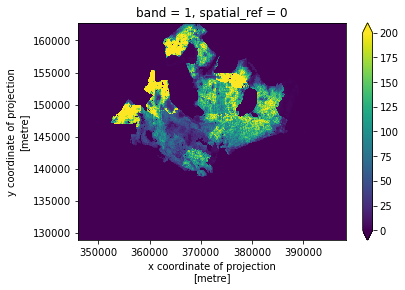

In [90]:
pop_proj.plot(vmin=0, vmax=200)

In [91]:
arr = pop_proj.values
affine = pop_proj.rio.transform()

In [92]:
%%time 
stats = rasterstats.zonal_stats(
    tess.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 2min 1s, sys: 4.52 s, total: 2min 6s
Wall time: 2min 6s


In [93]:
tess['population'] = [x['mean'] for x in stats]

In [94]:
mask = tess.population < 0
tess.population[mask] = 0

<ipython-input-94-4a6174b356ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tess.population[mask] = 0


In [96]:
tess.population = tess.population.fillna(0)

### NDVI

In [97]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"
tiles = geopandas.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [98]:
extent = geopandas.GeoSeries(box(*tess.total_bounds), crs=tess.crs).to_crs(tiles.crs).iloc[0]

In [99]:
meta = tiles[tiles.intersects(extent)]

In [100]:
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
meta

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


URL   EPSG UTMtile  \
4175  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32648     48N   
4176  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32648     48N   

          minX  minY      maxX      maxY      size  size_unit  size_bytes  \
4175  398980.0   0.0  631940.0  186630.0  1.855471  gigabytes  1992296918   
4176  166020.0   0.0  398980.0  186630.0  2.217685  gigabytes  2381221583   

                                               geometry  \
4175  POLYGON ((106.18563 0.00000, 106.18614 1.68813...   
4176  POLYGON ((104.09220 0.00000, 104.09181 1.68828...   

                                               dst_path  
4175  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
4176  ../../urbangrammar_samba/sp_sig_concept/ghs_co...

In [109]:
for index, row in meta.iterrows():
    download(row["URL"], row["dst_path"])


file_sizes: 100%|██████████████████████████| 1.99G/1.99G [01:11<00:00, 27.8MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_587-0000069888-0000023296.tif
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


In [110]:
extent = geopandas.GeoSeries(box(*tess.total_bounds), crs=tess.crs).to_crs('epsg:32648').iloc[0]

In [113]:
arrays = []
for path in meta.dst_path:
    r = rioxarray.open_rasterio(path)
    sub = r.rio.clip([mapping(extent)])
    arrays.append(sub)

In [114]:
from rioxarray.merge import merge_arrays

In [115]:
merged = merge_arrays(arrays)

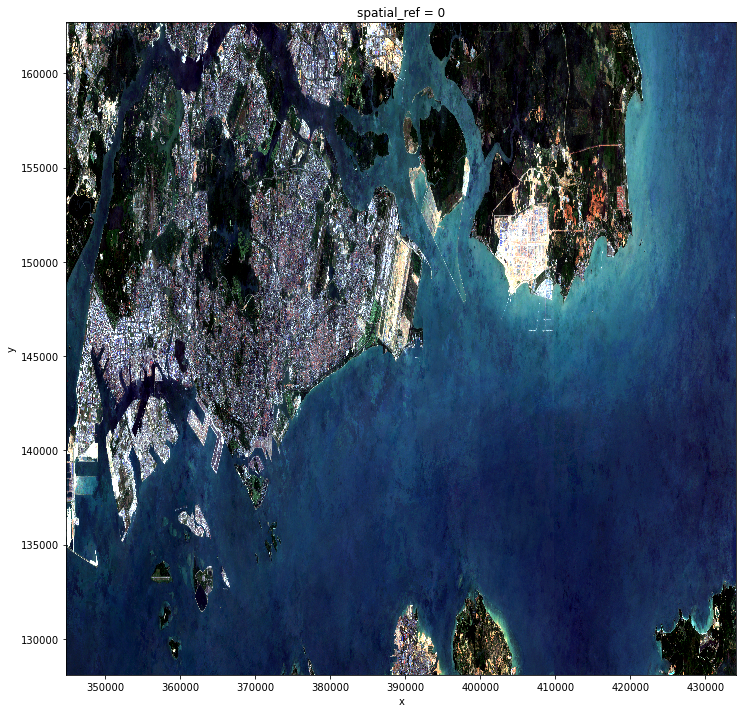

In [116]:
def minmax(a, 
           bottom=0, 
           top=255, 
           min_cut=2.5, 
           max_cut=98.5
          ):
    vals = a.to_series().values
    min_bin = percentile(vals, min_cut)
    max_bin = percentile(vals, max_cut)
    a = xarray.where(a > max_bin, max_bin, a)
    a = xarray.where(a < min_bin, min_bin, a)
    a_std = (a - a.min()) / (a.max() - a.min())
    a_scaled = a_std * (top - bottom) + bottom
    return a_scaled.astype(int)

zmerged.sel(band=[1, 2, 3]).groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12))

In [117]:
proj = merged.rio.reproject(tess.crs)

In [127]:
ndvi = (proj.sel(band=4).astype(float) - proj.sel(band=1).astype(float)) / (proj.sel(band=4).astype(float) + proj.sel(band=1).astype(float))

In [128]:
ndvi.min(), ndvi.max()

(<xarray.DataArray ()>
 array(-0.52026197)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(0.79438852)
 Coordinates:
     spatial_ref  int64 0)

In [129]:
affine = ndvi.rio.transform()

In [130]:
%%time
stats = rasterstats.zonal_stats(
    tess.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 2min 13s, sys: 4.22 s, total: 2min 17s
Wall time: 2min 17s


In [131]:
tess['ndvi'] = [x["mean"] for x in stats]

<AxesSubplot:>

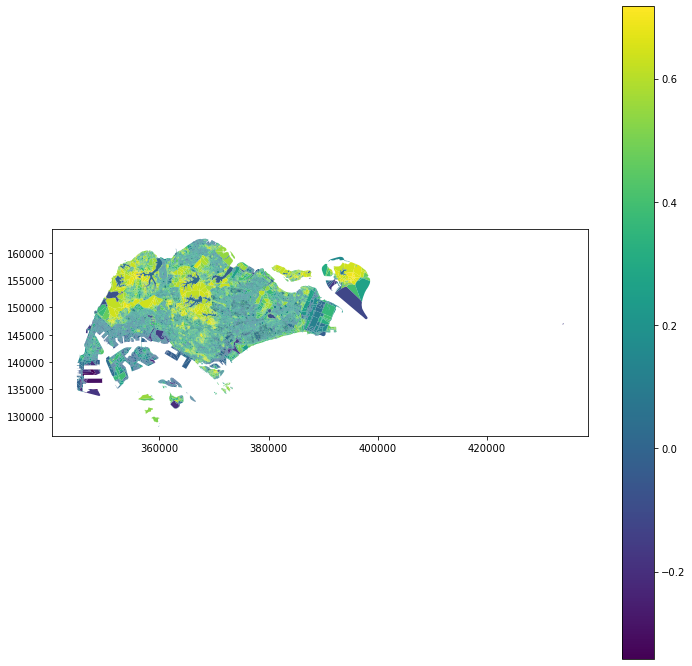

In [132]:
tess.plot('ndvi', legend=True, figsize=(12, 12))

### Night lights

From https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.


In [133]:
download("https://www.dropbox.com/s/r5qg4w7iqd8b7qk/SVDNB_npp_20191101-20191130_75N060E_vcmcfg_v10_c201912131600.tgz?dl=1",
         folder + "night_lights", kind="tar.gz", replace=True)

Creating data folder...
Extracting tar.gz file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/singapore/night_lights


'../../urbangrammar_samba/sp_sig_concept/singapore/night_lights'

In [134]:
nl = xarray.open_rasterio(folder + 'night_lights/SVDNB_npp_20191101-20191130_75N060E_vcmcfg_v10_c201912131600.avg_rade9h.tif')

In [135]:
bounds = gpd.GeoSeries(box(*tess.total_bounds), crs=tess.crs).to_crs(nl.crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [136]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(tess.crs)

In [137]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [138]:
%%time 
stats_nl = rasterstats.zonal_stats(
    tess.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 2min 11s, sys: 4.21 s, total: 2min 15s
Wall time: 2min 15s


In [139]:
tess['lights'] = [x['mean'] for x in stats_nl]

<AxesSubplot:>

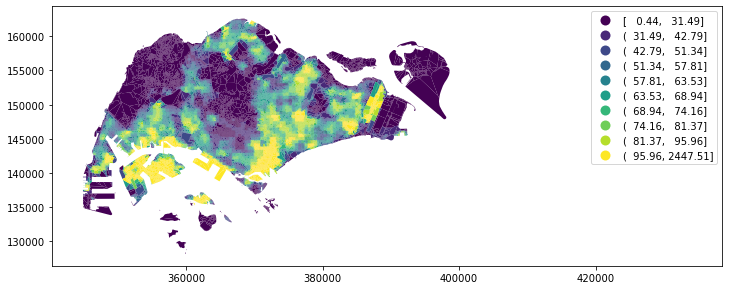

In [142]:
tess.plot("lights", legend=True, figsize=(12, 12), scheme='quantiles', k=10)

In [144]:
tess.drop(columns=["tessellation", 'nodeID']).to_parquet(folder + "func_data_tess.pq")

## Cluster analysis

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from clustergram import Clustergram
from sklearn.cluster import KMeans
from sklearn import preprocessing
import pickle

In [5]:
form = pd.read_parquet(folder + "convolutions.pq")
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation', 'buildings', 'tID'])

In [6]:
form = form.replace(np.inf, np.nan)

In [7]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(form)

In [8]:
data[np.isnan(data)] = 0

In [9]:
cg_form = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_form.fit(data)

K=1 fitted in 1.3451201915740967 seconds.
K=2 fitted in 2.161834478378296 seconds.
K=3 fitted in 3.325782060623169 seconds.
K=4 fitted in 4.586164712905884 seconds.
K=5 fitted in 4.583633184432983 seconds.
K=6 fitted in 5.907019138336182 seconds.
K=7 fitted in 5.551816940307617 seconds.
K=8 fitted in 6.683009147644043 seconds.
K=9 fitted in 7.9119768142700195 seconds.
K=10 fitted in 8.039777278900146 seconds.
K=11 fitted in 8.171895742416382 seconds.
K=12 fitted in 9.621356010437012 seconds.
K=13 fitted in 11.82795262336731 seconds.
K=14 fitted in 13.217310428619385 seconds.
K=15 fitted in 12.691669702529907 seconds.
K=16 fitted in 13.650453329086304 seconds.
K=17 fitted in 15.23560619354248 seconds.
K=18 fitted in 13.98452615737915 seconds.
K=19 fitted in 14.826198816299438 seconds.
K=20 fitted in 21.778929471969604 seconds.
K=21 fitted in 15.551012992858887 seconds.
K=22 fitted in 20.39061450958252 seconds.
K=23 fitted in 18.467601537704468 seconds.
K=24 fitted in 19.96260643005371 s

(-12.0, 25.0)

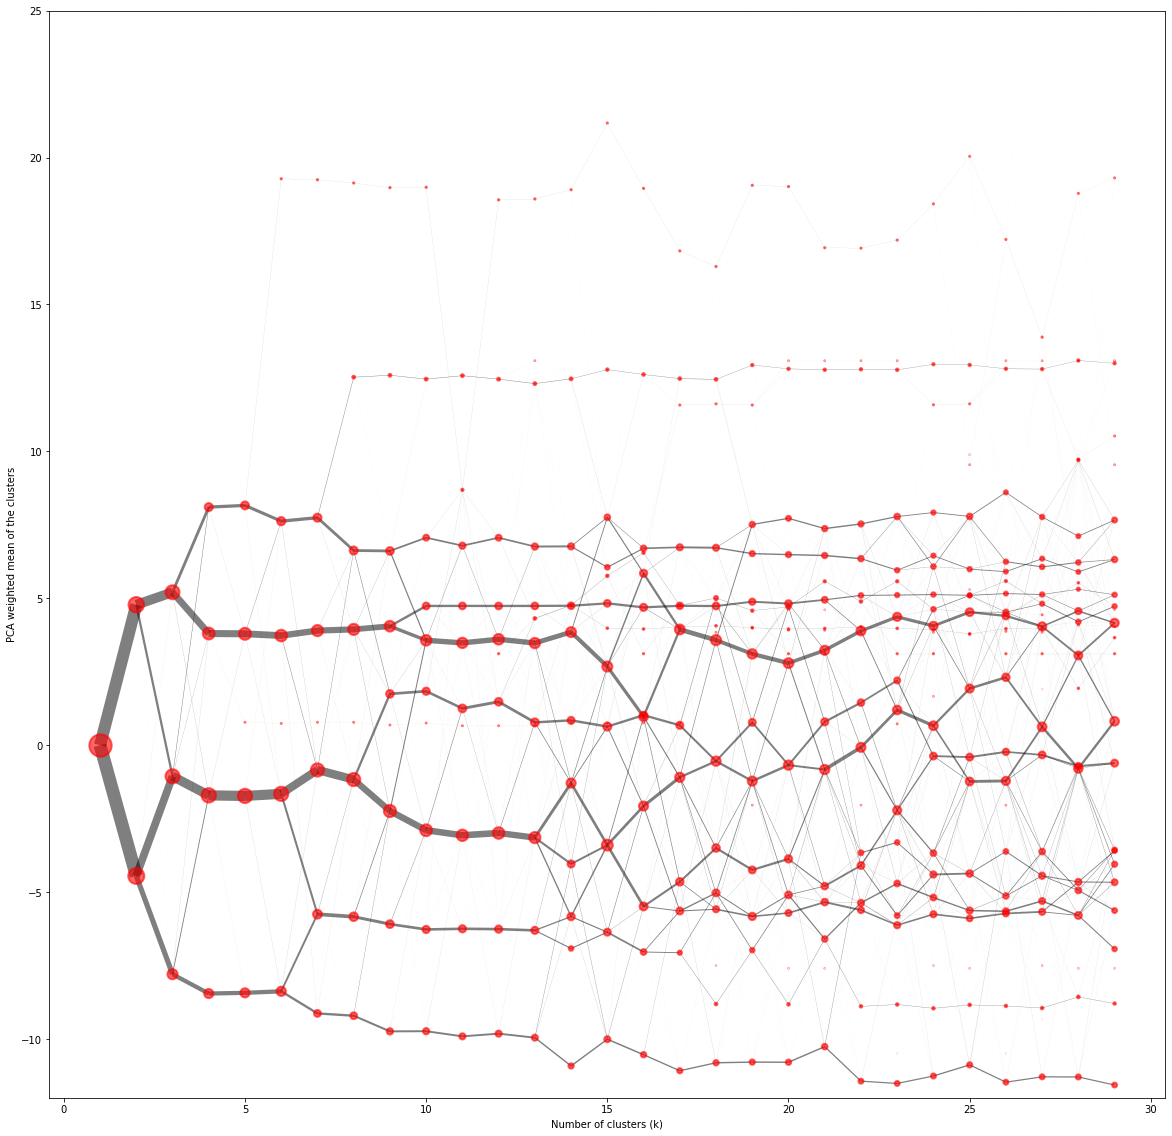

In [13]:
ax = cg_form.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-12, 25)

In [11]:
with open(folder + 'clustergram_form.pickle','wb') as f:
    pickle.dump(cg_form, f)

In [16]:
tess['clusters_form'] = cg_form.labels[10].values

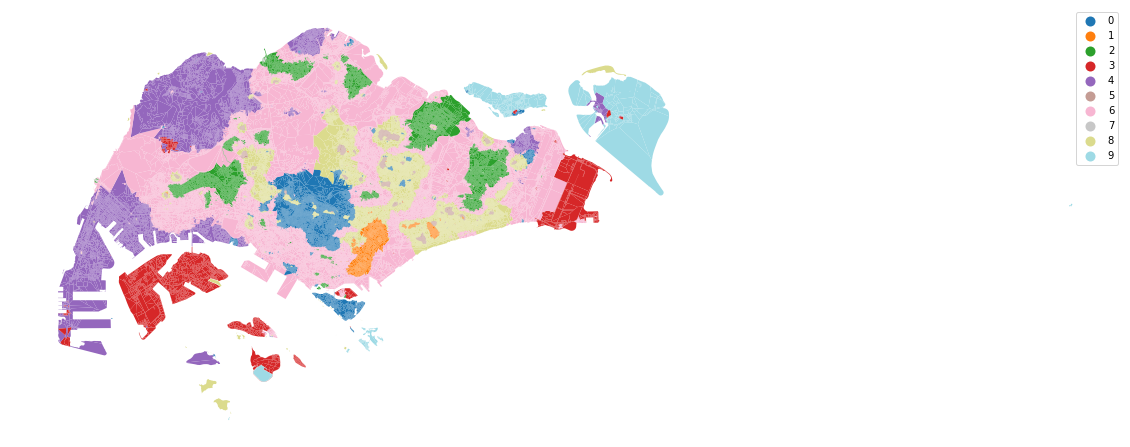

In [17]:
ax = tess.plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

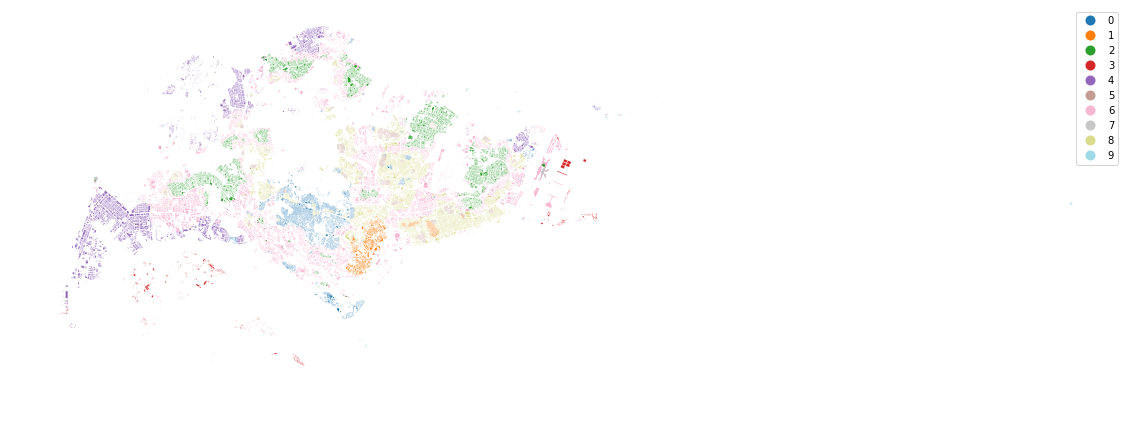

In [18]:
ax = tess.set_geometry('buildings').plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### Function

In [21]:
function_data = pd.read_parquet(folder + "func_data_tess.pq")

In [22]:
use = pd.get_dummies(function_data.use)

In [23]:
scaler = preprocessing.StandardScaler()
f_data = scaler.fit_transform(function_data.drop(columns=["use"]))

In [24]:
f_data.shape

(134922, 8)

In [25]:
f_data = np.hstack([f_data, use.values])

In [26]:
f_data.shape

(134922, 14)

In [27]:
np.isnan(f_data).any().any()

False

In [28]:
cg_function = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_function.fit(f_data)

K=1 fitted in 0.7764382362365723 seconds.
K=2 fitted in 1.4144949913024902 seconds.
K=3 fitted in 1.984039545059204 seconds.
K=4 fitted in 2.1764419078826904 seconds.
K=5 fitted in 2.003382444381714 seconds.
K=6 fitted in 2.511932134628296 seconds.
K=7 fitted in 2.0420327186584473 seconds.
K=8 fitted in 2.3307690620422363 seconds.
K=9 fitted in 2.8213562965393066 seconds.
K=10 fitted in 3.869300365447998 seconds.
K=11 fitted in 3.4408762454986572 seconds.
K=12 fitted in 3.74088454246521 seconds.
K=13 fitted in 4.74127197265625 seconds.
K=14 fitted in 5.3450047969818115 seconds.
K=15 fitted in 5.65937066078186 seconds.
K=16 fitted in 5.548888444900513 seconds.
K=17 fitted in 6.886349201202393 seconds.
K=18 fitted in 8.079010963439941 seconds.
K=19 fitted in 9.080941915512085 seconds.
K=20 fitted in 8.3546781539917 seconds.
K=21 fitted in 10.599517345428467 seconds.
K=22 fitted in 12.19663143157959 seconds.
K=23 fitted in 13.285515546798706 seconds.
K=24 fitted in 12.042384386062622 seco

(-3.0, 8.0)

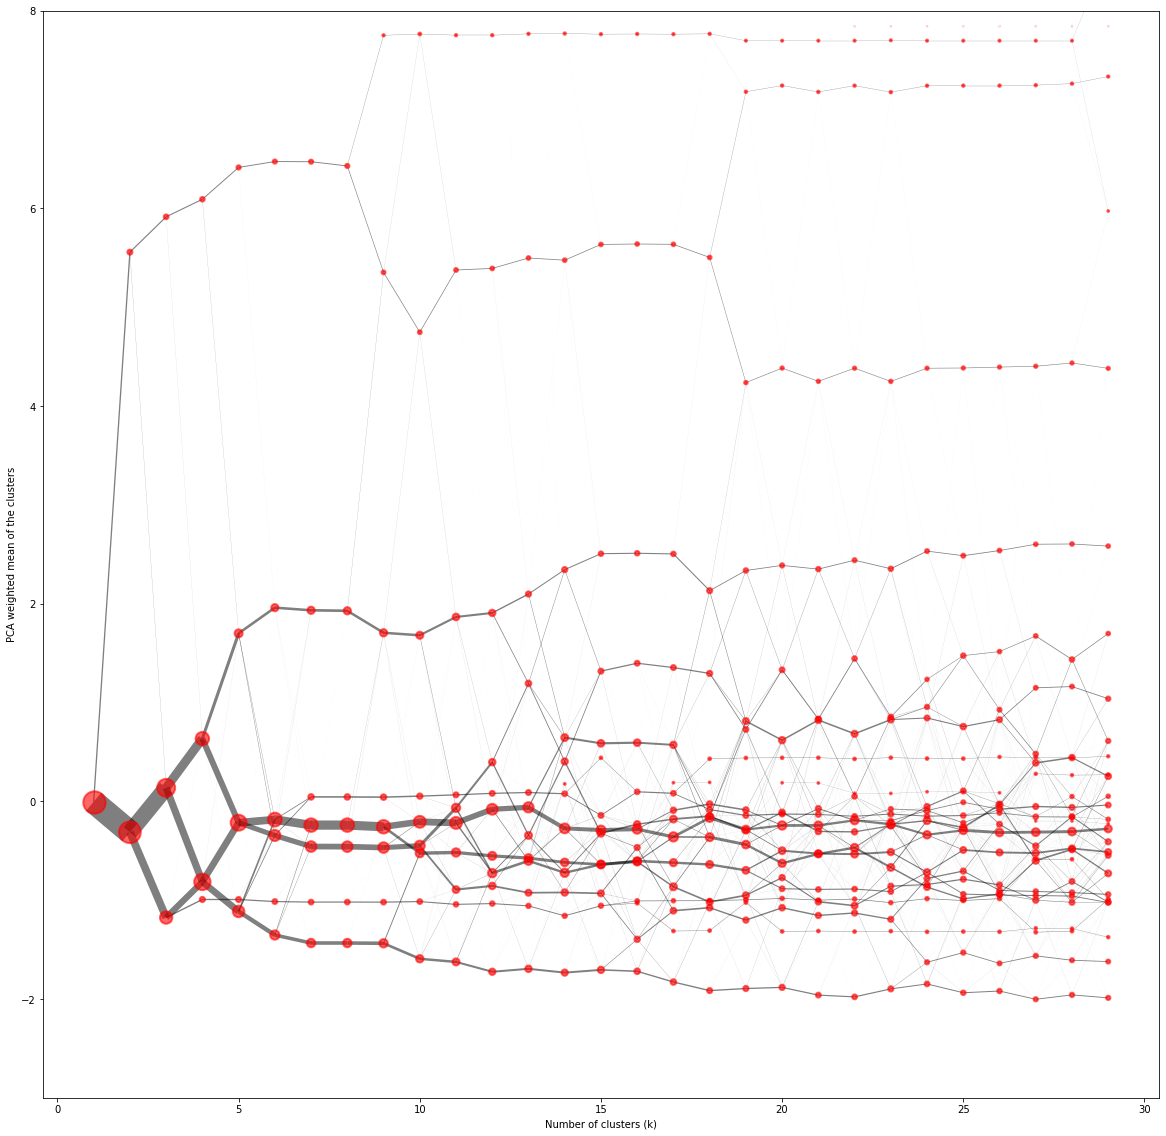

In [31]:
ax = cg_function.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-3, 8)

In [30]:
with open(folder + 'clustergram_function.pickle','wb') as f:
    pickle.dump(cg_function, f)

In [32]:
tess['clusters_function'] = cg_function.labels[9].values

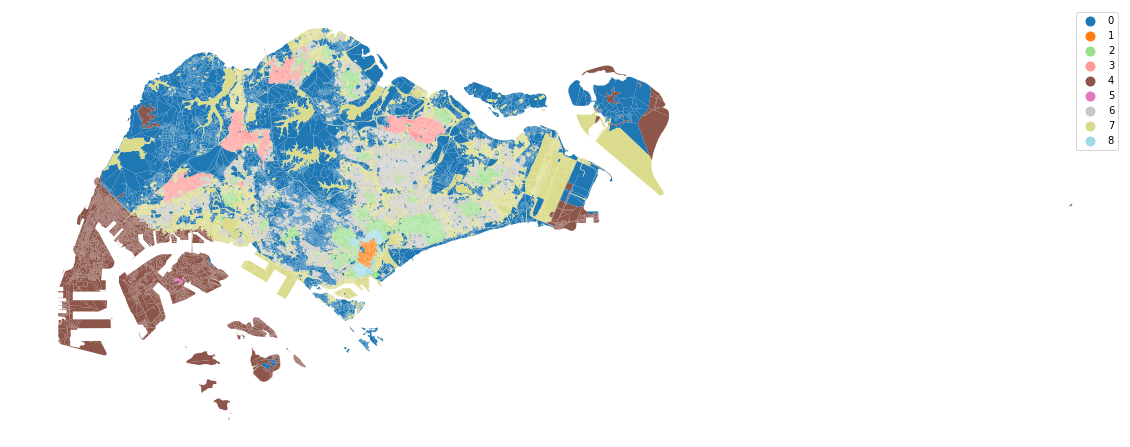

In [33]:
ax = tess.plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

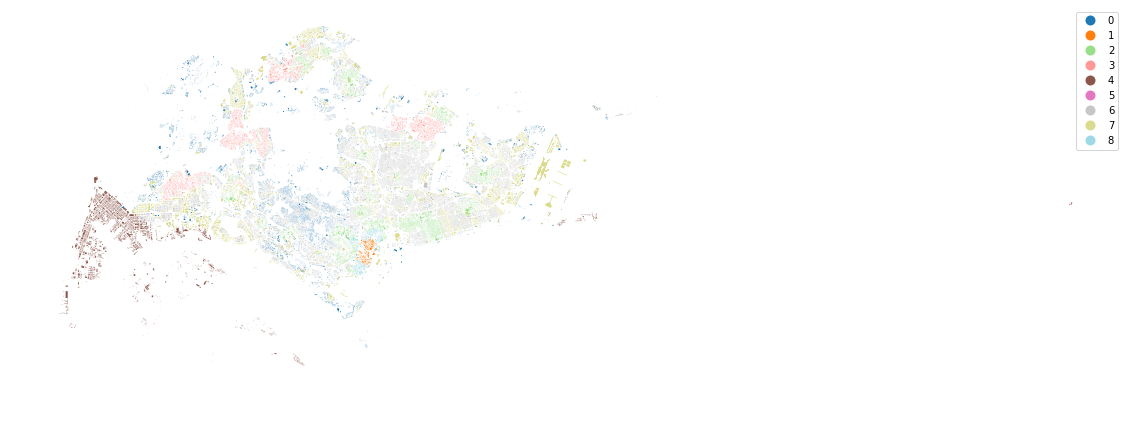

In [34]:
ax = tess.set_geometry('buildings').plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### Spatial Signatures

In [35]:
ss_data = np.hstack([data, f_data])

In [36]:
cg_ss = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_ss.fit(ss_data)

K=1 fitted in 1.2591218948364258 seconds.
K=2 fitted in 2.2755961418151855 seconds.
K=3 fitted in 3.0549662113189697 seconds.
K=4 fitted in 3.7564198970794678 seconds.
K=5 fitted in 4.678791522979736 seconds.
K=6 fitted in 4.929872751235962 seconds.
K=7 fitted in 7.506360054016113 seconds.
K=8 fitted in 7.673715829849243 seconds.
K=9 fitted in 8.514847040176392 seconds.
K=10 fitted in 9.035099267959595 seconds.
K=11 fitted in 9.754722118377686 seconds.
K=12 fitted in 9.858472347259521 seconds.
K=13 fitted in 12.23591136932373 seconds.
K=14 fitted in 14.329404592514038 seconds.
K=15 fitted in 15.388853311538696 seconds.
K=16 fitted in 14.817114114761353 seconds.
K=17 fitted in 16.235864877700806 seconds.
K=18 fitted in 16.521358966827393 seconds.
K=19 fitted in 16.69776153564453 seconds.
K=20 fitted in 20.85137152671814 seconds.
K=21 fitted in 21.157763957977295 seconds.
K=22 fitted in 23.148736715316772 seconds.
K=23 fitted in 22.140355587005615 seconds.
K=24 fitted in 20.1135373115539

(-12.0, 25.0)

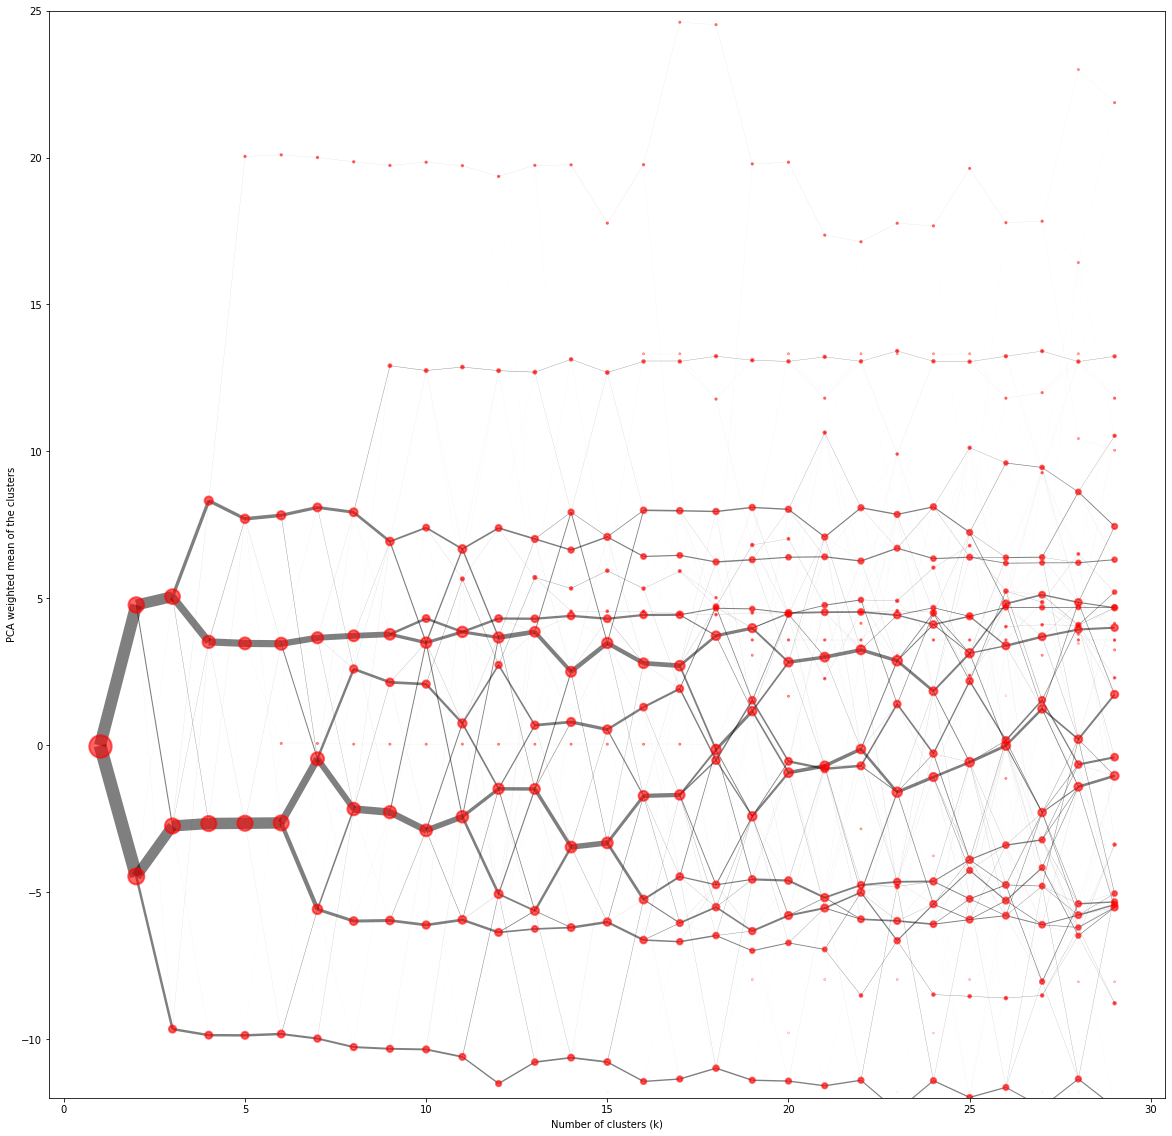

In [40]:
ax = cg_ss.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-12, 25)

In [38]:
with open(folder + 'clustergram_ss.pickle','wb') as f:
    pickle.dump(cg_ss, f)

In [41]:
tess['clusters'] = cg_ss.labels[16].values

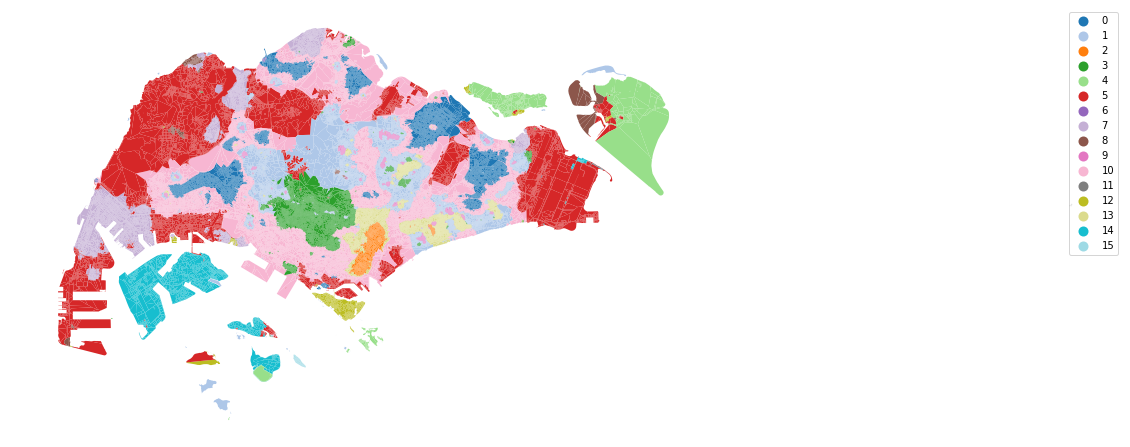

In [42]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

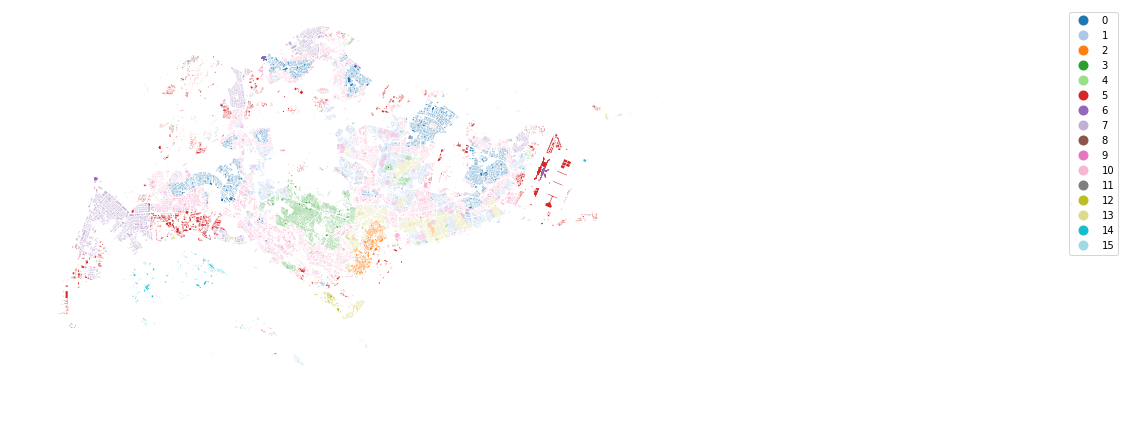

In [44]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [45]:
%time km = KMeans(n_clusters=16, n_init=1000, random_state=12345).fit(ss_data)

CPU times: user 3h 43min 46s, sys: 1h 12min 21s, total: 4h 56min 8s
Wall time: 24min 46s


In [46]:
tess['clusters'] = km.labels_

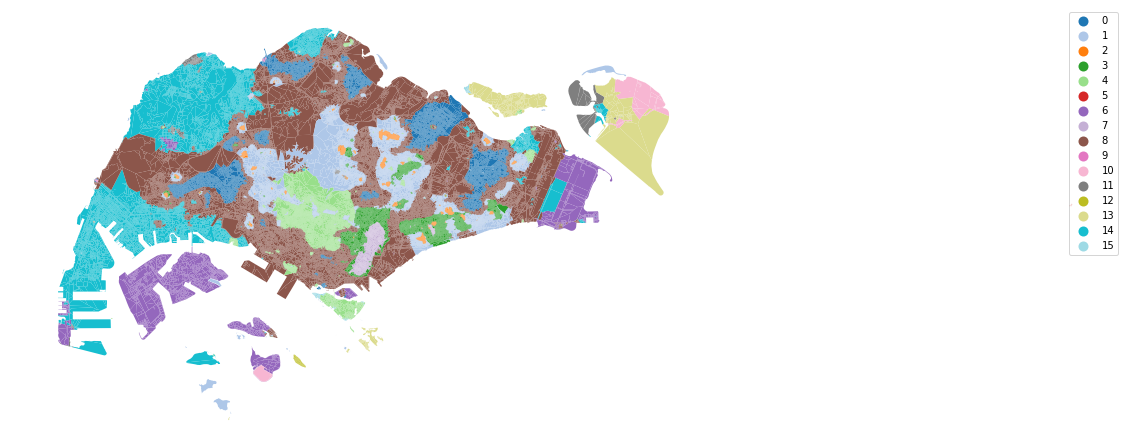

In [47]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

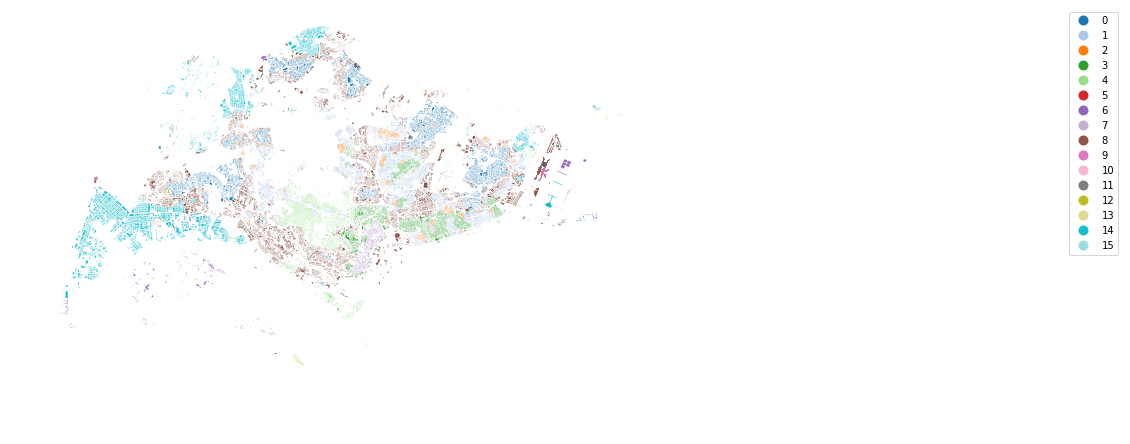

In [48]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [54]:
tess[['tID', 'clusters', 'clusters_form', 'clusters_function']].to_parquet(folder + "cluster_labels.pq")
tess[['tID', 'clusters']].to_csv(folder + "FINAL_cluster_labels.csv")

In [ ]:
sigbn